# G4Hive algorithm timeline visualization

I'm splitting this off into its own dedicated note just for visualization the algorithm timeline of G4Hive.

In this case I don't need to load in all of the results of a scaling campaign, but I need to be able to load individual jobs from different campaigns and draw them one at a time.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
%matplotlib notebook

In [18]:
# Local imports
from utils.prep import parse_job_result
from utils.timing import print_timing_summary, get_avg_throughput, calc_alg_timings

In [9]:
ls

AvgThruputTest.ipynb              results_aibuild_1mu_2016_07_22/
G4HiveAna_1muon.ipynb             results_aibuild_tt_2016_05_21/
G4HiveAna_1muon_knl.ipynb         results_aibuild_tt_2016_05_25/
G4HiveAna_ttbar.ipynb             results_aibuild_tt_2016_05_31/
README.md                         results_cori_1mu_2016_05_17/
TestPickle.ipynb                  results_endeavour_1mu/
ThroughputTable.ipynb             results_endeavour_1mu_2016_08_06/
TimelineVisualization.ipynb       results_endeavour_1mu_2016_08_14/
parseResults.py*                  test.pkl
results_aibuild_1mu_2016_05_19/   utils/


## Helper code

In [52]:
# A color map for the algorithms
alg_color_map = {'SGInputLoader' : 'yellow',
                 'BeamEffectsAlg' : 'blue',
                 'G4AtlasAlg' : 'red',
                 'StreamHITS' : 'green',
                 #'AthOutSeq' : 'yellow',
                 #'AthRegSeq' : 'purple',
                }

class TimelineThreadData():
    """Simple struct for holding relevant timeline data in one thread"""
    def __init__(self, tid):
        self.tid = tid

def get_timeline_thread_data(job):
    """Get the processed timeline results per thread"""
    # Get the unique thread IDs
    tids = job.timeline_results['tids']
    unique_tids = np.unique(tids)
    assert(len(unique_tids) == job.nThread) # sanity check
    # Create and fill the per-thread timeline data
    ttds = [TimelineThreadData(tid) for tid in unique_tids]
    for ttd in ttds:
        indices = tids == ttd.tid
        algs = job.timeline_results['algs'][indices]
        ttd.colors = np.array([alg_color_map.get(alg, 'black') for alg in algs])
        starts = job.alg_starts[indices]
        durations = job.alg_durations[indices]
        ttd.times = np.column_stack((starts, durations))
    return ttds

def draw_timeline(tldata, figsize=(12, 6), num_thread=None, leg_loc=1):
    """Draw timeline plot from timeline thread data"""
    if num_thread is not None:
        tldata = tldata[:num_thread]
    nThreads = len(tldata)
    plt.figure(figsize=(12, 6))
    plt.title('Event loop timeline')
    bar_thickness = 0.8
    for i, t in enumerate(tldata):
        ylow = (i + 1.) - bar_thickness/2
        plt.broken_barh(t.times, [ylow, bar_thickness],
                        facecolors=t.colors, linewidth=0)
    # Fake bar objects to populate the legend
    legbars = [mpatch.Rectangle((0, 0), 1, 1, fc=c)
               for c in alg_color_map.values()]
    plt.xlabel('Event loop time [s]')
    plt.ylabel('Thread')
    plt.yticks(range(1, nThreads+1))
    plt.ylim(ymax=nThreads*1.05 + 0.5)
    plt.xlim(xmin=0)
    plt.legend(legbars, alg_color_map.keys(), loc=leg_loc);

## Xeon, single-mu

In [33]:
mem_file = 'results_aibuild_1mu_2016_07_22/mem.10_0_10000.csv'
time_file = 'results_aibuild_1mu_2016_07_22/timeline.10_0_10000.log'
job = parse_job_result(mem_file, time_file)
calc_alg_timings(job)
tldata_by_thread = get_timeline_thread_data(job)
print_timing_summary([job])
print('Throughput: %g events/s' % get_avg_throughput(job))

Threads Events Job-time Init-time Loop-time Final-time
     10  10000    988.4     249.5     736.4        2.4
Throughput: 13.5987 events/s


<IPython.core.display.Javascript object>


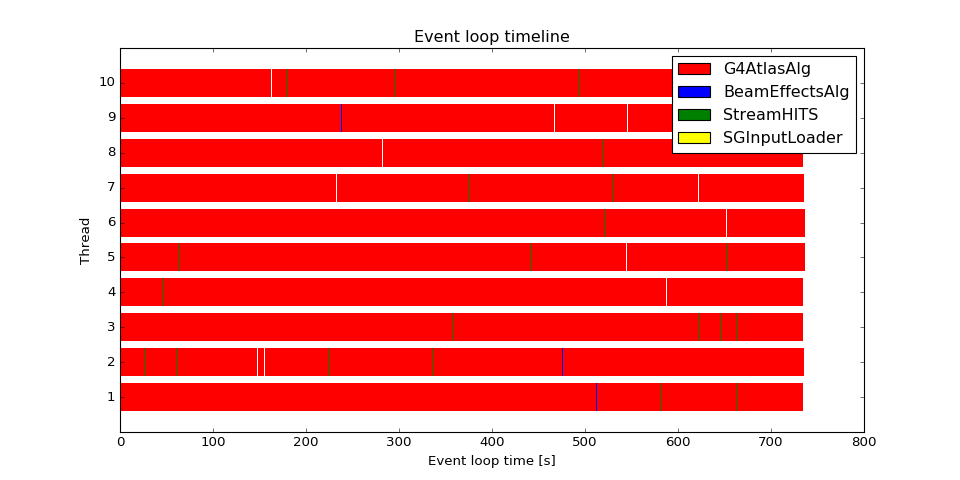

In [47]:
# Prepare the plot
draw_timeline(tldata_by_thread, num_thread=10)

## Xeon Phi, single-mu

In [48]:
mem_file = 'results_endeavour_1mu/mem.10_0_10000.csv'
time_file = 'results_endeavour_1mu/timeline.10_0_10000.log'
job = parse_job_result(mem_file, time_file)
calc_alg_timings(job)
tldata_by_thread = get_timeline_thread_data(job)
print_timing_summary([job])
print('Throughput: %g events/s' % get_avg_throughput(job))

Threads Events Job-time Init-time Loop-time Final-time
     10  10000   5471.8     918.6    4548.0        5.2
Throughput: 2.24582 events/s


<IPython.core.display.Javascript object>


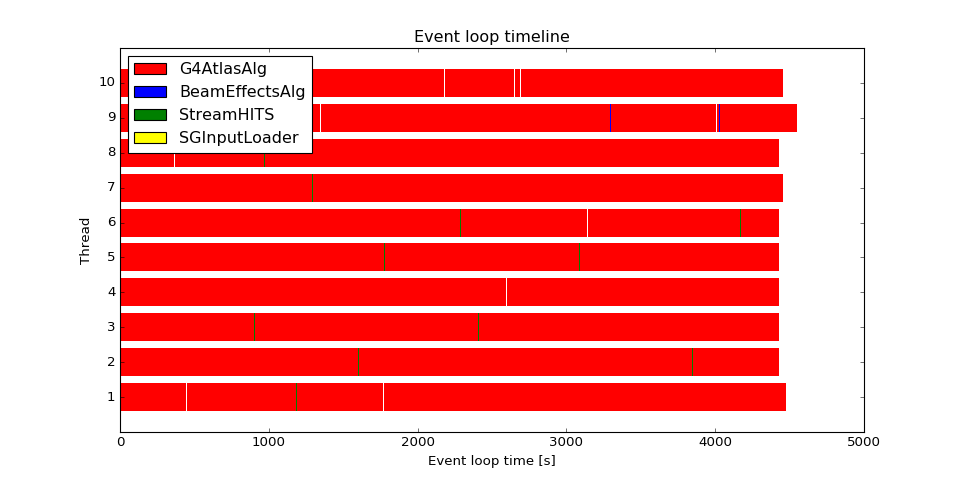

In [54]:
# Prepare the plot
draw_timeline(tldata_by_thread, num_thread=10, leg_loc=2)